# Forecasting PJM West

# Note:
This is the second notebook of the PJM West coast EDA, in this Notebook we will experiment with several models: 
Linear Regression, XGBoost and finally Prophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


%matplotlib inline

plt.style.use("dark_background")


# Creating train and test sets

In [2]:
# Importing the cleaned data from part 1
pjm_data = pd.read_csv("data/clean.csv",index_col="Datetime",parse_dates=["Datetime"])


In [4]:
print(pjm_data.head())
size = int(0.75 * len(pjm_data))
features = ["day","week","month","year","hour","dayofyear"]
X_train,X_test = pjm_data[features].iloc[:size], pjm_data[features].iloc[size:]
y_train,y_test = pjm_data["MW"].iloc[:size], pjm_data["MW"].iloc[size:]

print("X: ",X_train.shape,X_test.shape)
print("Y: ",y_train.shape,y_test.shape)


                         MW  day  month  year  week  dayofyear  hour
Datetime                                                            
2002-12-31 01:00:00  5077.0    1     12  2002     1        365     1
2002-12-31 02:00:00  4939.0    1     12  2002     1        365     2
2002-12-31 03:00:00  4885.0    1     12  2002     1        365     3
2002-12-31 04:00:00  4857.0    1     12  2002     1        365     4
2002-12-31 05:00:00  4930.0    1     12  2002     1        365     5
X:  (98658, 6) (32886, 6)
Y:  (98658,) (32886,)


## Defining a plotting function 

In [58]:
def plot_results(y,preds,title="",scale=0):
    # Plotting the results
    plt.figure(figsize=(10,10))
    plt.plot(X_test.index[scale:],y,color="blue")
    plt.plot(X_test.index[scale:],preds,color="red")
    plt.title(title)
    plt.legend(["Actual Values","Pedictions"])
    plt.show()
    
    

## Defining and error printing function

In [39]:

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_err(y,preds):
    print("MAE",mean_absolute_error(y,preds))
    print("RMSE",np.sqrt(mean_squared_error(y,preds)))
    print("MAPE",mean_absolute_percentage_error(y,preds))

# Linear Regression

In [40]:
reg = LinearRegression().fit(X_train,y_train)
print("Train score",reg.score(X_train,y_train))
print("Test score",reg.score(X_test,y_test))

reg_preds = reg.predict(X_test)



Train score 0.23774387502888786
Test score 0.18962927399909868


In [41]:
print_err(y_test,reg_preds)

MAE 709.7176649703629
RMSE 904.3919649325588
MAPE 12.622721158509128


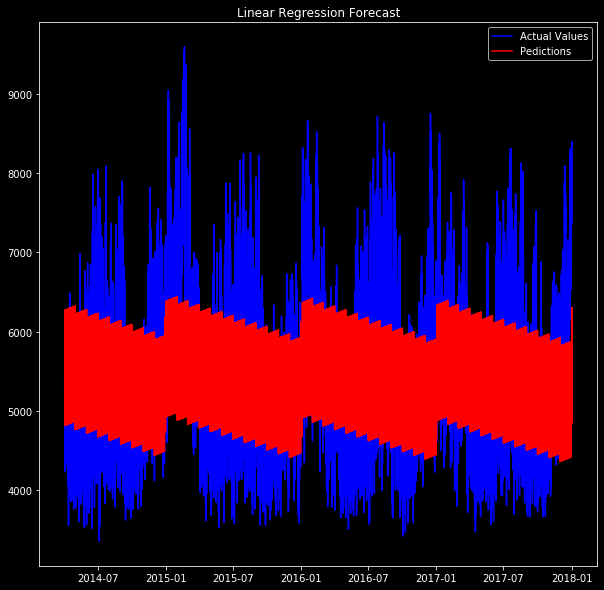

In [63]:
plot_results(y_test,reg_preds, "Linear Regression Forecast")

**Comments:** Well even that the model is poor, it's not that bad actually for such a  simple model with a Mean Absolute error of 700 MW.


# XGBoost Model

XGBoost is a high performance implementation of the gradient boosting framework, in this case if we have $k$ regression trees, where each tree optimize the previous one, we can define the predicted target $\hat{y}$ as: 


$$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$$

We wish to minimize the following objective function: (loss + regularization (either $L^1$
 or $L^2$)

$$ \text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k) $$ 

In [10]:
import xgboost as xgb

train_matrix = xgb.DMatrix(data=X_train,label=y_train)
test_matrix = xgb.DMatrix(data=X_test,label=y_test)

# Parameters, need hypertuning
xg_reg = xgb.XGBRegressor(n_estimators = 1000)



In [11]:
xg_fit = xg_reg.fit(X_train,y_train)
xg_preds = xg_fit.predict(X_test)

In [12]:
print_err(y_test,xg_preds)


MAE 633.7102246251136
RMSE 840.3147861669037
MAPE 11.300472919922408


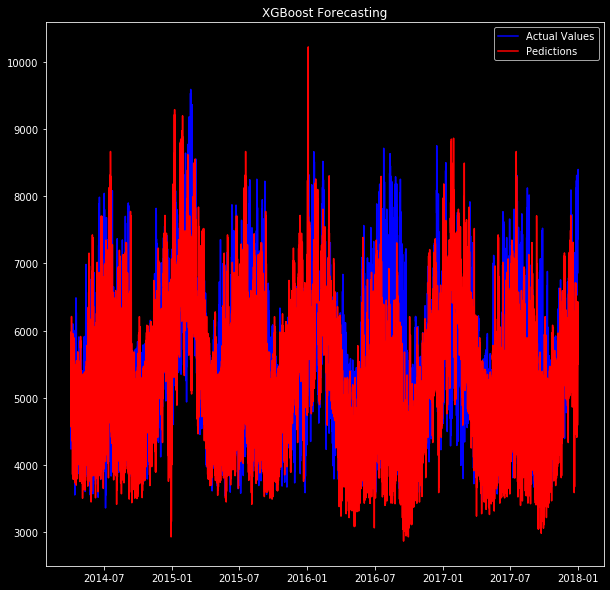

In [64]:
plot_results(y_test,xg_preds,"XGBoost Forecasting",0)



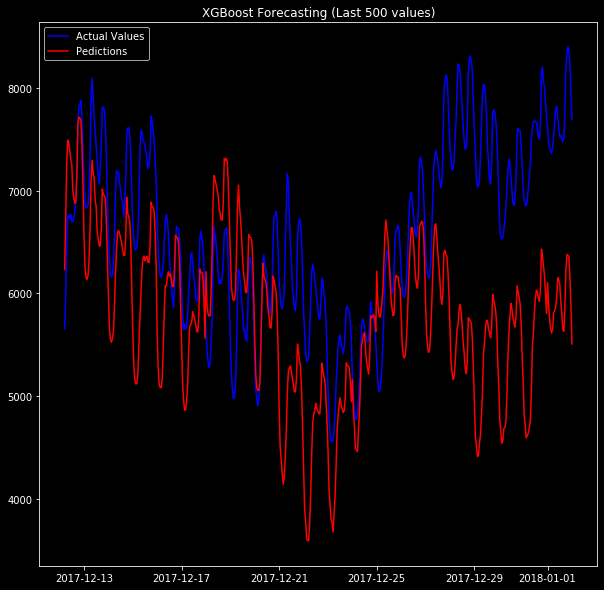

In [65]:
#Plot the last 500 values
plot_results(y_test[-500:],xg_preds[-500:],"XGBoost Forecasting (Last 500 values)",-500)

**Comments:** As we can see our XGBoost is giving great results with only 11% off. Let's take a look now at prophet.

# Forecasting with Prophet

Prophet is a framework from facebook to forecast time series by decomposing the time series into components: trend, seasonality, Holidays and residuals. 

$$ x(t) = T(t) + S(t) + H(t) + \epsilon(t) $$

S(t) is approximated using a fourier series with a period P = 365 by default, we can choose the fourier order $n$ of each seasonality:

$$ \sum_{i=1}^n a_n cos( \frac{n\pi}{P} t ) + b_n sin( \frac{n\pi}{P} t  ) $$

In [19]:
from fbprophet import Prophet

m = Prophet()
m.add_seasonality(name='daily', period=1, fourier_order=1)
m.add_seasonality(name='weekly', period=7, fourier_order=3)
m.add_seasonality(name='Monthly', period=30.5, fourier_order=5)







In [27]:
pjm_data["ds"] = pjm_data.index
pjm_data["y"] = pjm_data.MW

pjm_train , pjm_test = pjm_data.iloc[:size],pjm_data.iloc[size:]

print(pjm_train.shape)


(98658, 9)


In [28]:
# Fitting the model
m.fit(pjm_train)

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Found custom seasonality named 'daily', disabling built-in 'daily' seasonality.


Next we will split the dataframe into chunks because we have too much data and the machine I'm using for now is not very performant and forecast with every chunk

In [54]:
i = 0
forecast_list = []
for df_chunk in np.array_split(pjm_test,100):
    forecast = m.predict(df_chunk)
    forecast_list.append(forecast)
    i +=1
    print("done for ",i,"th chunk")
    
final_forecast = pd.concat(forecast_list) 

print(final_forecast.head())

done for  1 th chunk
done for  2 th chunk
done for  3 th chunk
done for  4 th chunk
done for  5 th chunk
done for  6 th chunk
done for  7 th chunk
done for  8 th chunk
done for  9 th chunk
done for  10 th chunk
done for  11 th chunk
done for  12 th chunk
done for  13 th chunk
done for  14 th chunk
done for  15 th chunk
done for  16 th chunk
done for  17 th chunk
done for  18 th chunk
done for  19 th chunk
done for  20 th chunk
done for  21 th chunk
done for  22 th chunk


KeyboardInterrupt: 

MAE 911.193099046584
RMSE 1075.862772832366
MAPE 17.753127755897264


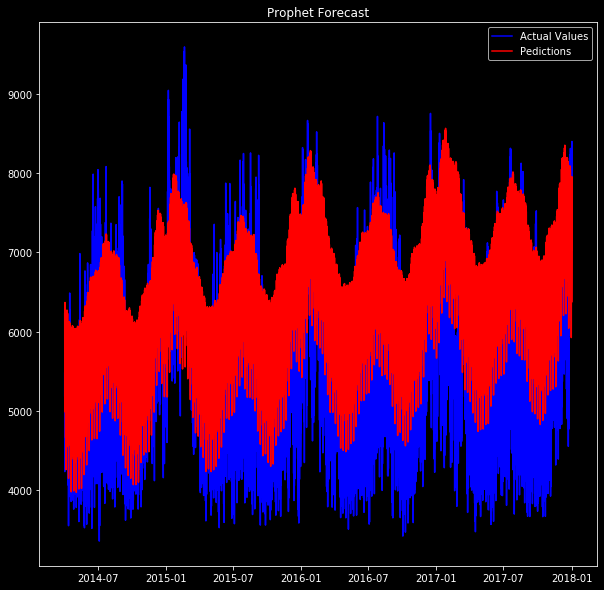

In [68]:
# Checking for errors
print_err(y_test,final_forecast.yhat)
plot_results(y_test,final_forecast.yhat, "Prophet Forecast",0)

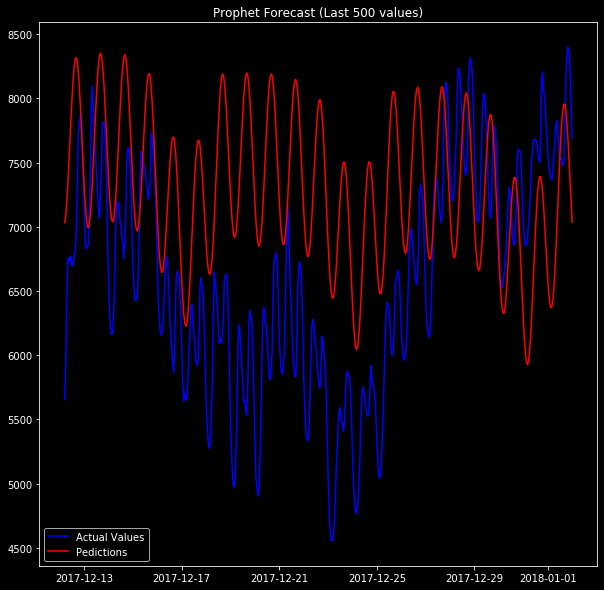

In [67]:
plot_results(y_test[-500:],final_forecast.yhat[-500:], "Prophet Forecast (Last 500 values)",-500)

As we can see, the forecast from facebook prophet is great too with only a 17% error which is highly acceptable for this case.


# Conclusion:

In the 3 tested models  XGBoost is the best performing one, it had a smaller error (11% vs 17%), and the training time for XGBoost was much shorter than Prophet where we had to chunk the dataframe into smaller chunks to avoid memory problems. Here is a summary for each model and the 3 metrics:

|   | MAE  | RMSE  | MAPE  |   |
|---|---|---|---|---|
| Linear Reg  | 704 |  904 | 12  |   
|  XGBoost |     633 |  840 | 11  |
|   Prophet |   911  |  1075 | 17  |

However Facebook prophet is still one of the best models in the industry for forecasting and I think that we can reduce the error by inspecting the model further and tuning parameters.